In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes
import numpy as np
from pathlib import Path

# Add project root to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import src.config as config

In [2]:
import src.loadProcessed as loadp

counts: pd.DataFrame = loadp.load_processed_count()
locations: pd.DataFrame = loadp.load_processed_locations()

In [3]:
# Take the intersection of those sets
common_sensors = (
    set(counts[counts['sensing_date'].dt.year == 2019]['sensor_id'].unique()) 
    & set(counts[counts['sensing_date'].dt.year == 2025]['sensor_id'].unique())
)

# Filter to only those sensors
counts_with_common_dates = counts[counts['sensor_id'].isin(common_sensors)]

# Limit to only 2019 and 2025 with non-zero values
data: pd.DataFrame = (
    counts_with_common_dates[
        counts_with_common_dates['sensing_date'].dt.year.isin([2019, 2025])
    ].query('daily_count > 0')
)
data['year'] = data['sensing_date'].dt.year.astype('category')
# data.drop(columns=['sensing_date'])


In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy.highlevel as phl
import math

# We want to log transform since counts have a power relation
log_data = data.copy()
log_data['daily_count'] = log_data['daily_count'].apply(math.log)

model = smf.mixedlm(
    'daily_count ~ year + day',     # Defines the response and fixed effects
    log_data,                       
    groups=log_data['sensor_id'],   # Defines how to cluster the data
    re_formula='~ year'             # Random effect that differs across the clusters
)
result = model.fit(reml=False)

print(result.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    daily_count
No. Observations:      34178      Method:                ML         
No. Groups:            49         Scale:                 0.2890     
Min. group size:       442        Log-Likelihood:        -27581.9033
Max. group size:       730        Converged:             Yes        
Mean group size:       697.5                                        
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 9.265    0.124  74.459 0.000  9.021  9.509
year[T.2025]             -0.311    0.064  -4.879 0.000 -0.437 -0.186
day[T.Monday]            -0.198    0.011 -18.196 0.000 -0.220 -0.177
day[T.Saturday]          -0.224    0.011 -20.604 0.000 -0.246 -0.203
day[T.Sunday]            -0.419    0.011 -38.417 0

In [5]:
model_2 = smf.mixedlm(
    'daily_count ~ day*year',     # Defines the response and fixed effects
    log_data,                       
    groups=log_data['sensor_id'],  # Defines how to cluster the data
    re_formula='~ year'            # Random effect that differs across the clusters
)
result_2 = model_2.fit(reml=False)

print(result_2.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      daily_count
No. Observations:       34178        Method:                  ML         
No. Groups:             49           Scale:                   0.2876     
Min. group size:        442          Log-Likelihood:          -27494.2870
Max. group size:        730          Converged:               Yes        
Mean group size:        697.5                                            
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      9.292    0.125  74.544 0.000  9.048  9.536
day[T.Monday]                 -0.175    0.016 -11.216 0.000 -0.206 -0.145
day[T.Saturday]               -0.319    0.016 -20.449 0.000 -0.350 -0.289
day[T.Sunday]                 -0.493    0.016 -31.552 0.

In [6]:
print(result.aic, result_2.aic)

55187.806515709555 55024.57400965493


The interactive model has a significantly lower AIC so it should be preffered, since days are roughly equally represented I can reconstruct the average yearly effect.

In [ ]:
log_fixed_year = result_2.params['year[T.2025]']
log_fixed_intercept = result_2.params['Intercept']

log_sensor_effects = pd.DataFrame.from_dict(
    result_2.random_effects,
    orient='index'
).rename(
    columns={
        'year[T.2025]': 'friday_year_effect',
        'Group' : 'intercept_deviation'
    }
)

for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday']:
    day_param = f'day[T.{day}]:year[T.2025]'
    if day_param in result_2.params:
        # Add fixed main effect + day×year effect + sensor random effect
        log_sensor_effects[f'{day.lower()}_year_effect'] = (
            log_fixed_year + result_2.params[day_param] + log_sensor_effects['friday_year_effect']
        )

log_sensor_effects['geometric_mean_pedestrians_2019'] = log_sensor_effects['intercept_deviation'] + log_fixed_intercept

# Since each day of the week has roughly the same number of counts, we can just take the mean of the day specific effects
log_sensor_effects['mean_year_effect'] = log_sensor_effects[[
    'monday_year_effect', 'tuesday_year_effect', 'wednesday_year_effect',
    'thursday_year_effect', 'friday_year_effect', 'saturday_year_effect', 'sunday_year_effect'
]].mean(axis=1)

log_sensor_effects = log_sensor_effects.drop(columns=['intercept_deviation'])


(0.0, 1.0)

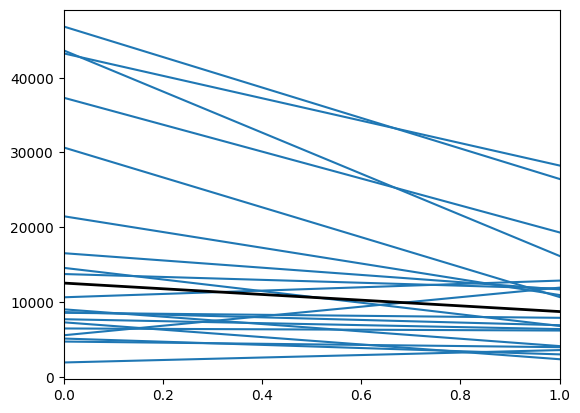

In [58]:
fig, ax = plt.subplots()

fixed_intercept = np.exp(log_fixed_intercept)
fixed_year_effect = np.exp(log_fixed_year)

convexivity_correction = np.exp(result_2.scale / 2)

sensor_effects: pd.DataFrame = log_sensor_effects.apply(np.exp)
sensor_effects['arithmetic_mean_pedestrians_2019'] = sensor_effects['geometric_mean_pedestrians_2019'] * convexivity_correction
 
for index, series in sensor_effects.sample(20).iterrows(): 
    ax.axline((0, series['arithmetic_mean_pedestrians_2019']), (1, series['arithmetic_mean_pedestrians_2019']*series['mean_year_effect']))

ax.axline(
    (0, fixed_intercept * convexivity_correction),
    (1, fixed_intercept * convexivity_correction * fixed_year_effect),
    color='black',
    linewidth=2,
    label='Average sensor'
)

ax.set_xlim(0, 1)

In [59]:
bad_sensors = (
    pd.Index(result.random_effects.keys())
    .difference(locations['sensor_id'])
)
print(f"Sensors in model but not in locations: {bad_sensors}")

data_clean = data[~data['sensor_id'].isin(bad_sensors)]

Sensors in model but not in locations: Index([], dtype='int64')


We see that there are a few sensors which do not have entries in our locations dataset. This means we cannot recover their locations however they still contain useful information for our regression so we will just stop considering them from here.

In [61]:
location_effects = pd.merge(
    sensor_effects, locations.drop(columns=['installation_date', 'note', 'status', 'location']), right_on='sensor_id', left_index=True, how='inner'
)
location_effects['percentage_change'] = round((location_effects['mean_year_effect'] - 1) * 100, 3)
location_effects.to_parquet(config.PROCESSED_DATA_DIR / 'location_effects.parquet')

In [62]:
data_clean.to_parquet(config.PROCESSED_DATA_DIR / 'analysis_data.parquet')